In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import os

1. Drop (remove) the following features
These either have very high missingness, duplicate information, or low relevance:

ORG_AR (redundant with WL_ORG)

REC_TX_PROCEDURE_TY (≈46 % missing)

DON_TY (low relevance)

REC_TX_DT (duplicate transplant date)

CAN_PREV_KI_TX_FUNCTN (≈99 % missing)

CAN_MALIG_TY (≈94 % missing)

CAN_CMV_STAT (≈99.9 % missing)

CAN_CREAT_CLEAR & CAN_CREAT_CLEAR_DT (≈96 % missing)

CAN_DIAB (78 % missing; superseded by CAN_DIAB_TY)

CAN_DIAL_DT (exact dialysis date not needed)

CAN_ANGINA (78 % missing; keep only the simpler CAD flag)

CAN_REM_COD (91 % missing cause‐of‐death codes)

2. Keep (retain) the following core features
All other columns carry essential demographic, clinical or laboratory information:

Identifiers: PX_ID, PERS_ID

Wait-list metadata: CAN_SOURCE, WL_ORG

Donor link: DONOR_ID

Demographics: CAN_AGE_AT_LISTING, CAN_GENDER, CAN_RACE, CAN_RACE_SRTR

Anthropometry & labs: CAN_BMI, CAN_MIN_FINAL_CREAT, CAN_MIN_PEAK_CREAT, CAN_TOT_ALBUMIN, CAN_MOST_RECENT_CREAT

Clinical status: CAN_FUNCTN_STAT, CAN_INIT_STAT, CAN_DGN, CAN_PREV_KI, CAN_PERIPH_VASC, CAN_MALIG, CAN_ACTIVATE_DT

Event dates: CAN_LISTING_DT, PERS_NEXTTX (transplant date), CAN_DEATH_DT

Key flags: CAN_ANGINA_CAD, CAN_PREV_TXFUS

Active/Inactive Status: CAN_LAST_ACT_STAT_DT, CAN_LAST_INACT_STAT_DT

In [44]:
subset_path = "/Users/chanyoungwoo/Thesis/Data_Extraction/extracted_subsets/cand_kipa_subset.csv"
cand = pd.read_csv(subset_path)

/var/folders/d8/czws1f3177g_k77xwyh5j8x40000gn/T/ipykernel_3813/2431972163.py:2: DtypeWarning: Columns (6,8,12,14,16,25,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  cand = pd.read_csv(subset_path)


In [45]:
to_drop = [
    "ORG_AR",
    "REC_TX_PROCEDURE_TY", "DON_TY",
    "REC_TX_DT", "CAN_PREV_KI_TX_FUNCTN",
    "CAN_MALIG_TY", "CAN_CMV_STAT",
    "CAN_CREAT_CLEAR", "CAN_CREAT_CLEAR_DT",
    "CAN_DIAB", "CAN_DIAL_DT",
    "CAN_ANGINA", "CAN_REM_COD",
]

In [46]:
cand_clean = cand.drop(columns=to_drop)
print(f"Shape before: {cand.shape}, after drop: {cand_clean.shape}")
cand_clean.head()

Shape before: (1199290, 52), after drop: (1199290, 39)


,PERS_ID,PX_ID,WL_ORG,CAN_GENDER,CAN_RACE,CAN_RACE_SRTR,CAN_ACTIVATE_DT,CAN_LISTING_DT,CAN_SOURCE,CAN_DEATH_DT,...,CAN_AGE_AT_LISTING,CAN_PREV_KI,CAN_INIT_SRTR_PEAK_PRA,CAN_INIT_CUR_PRA,CAN_INIT_ALLOC_PRA,CAN_INIT_STAT,CAN_LAST_ACT_STAT_DT,CAN_LAST_INACT_STAT_DT,PERS_NEXTTX,DONOR_ID
0,2958459.0,-1994541.0,KI,M,8.0,WHITE,1996-01-24,1993-01-13,R,NaN,...,35.0,0.0,4.0,4.0,4.0,4010.0,1997-05-01,NaN,1997-02-12,NaN
1,2954395.0,-1993046.0,KI,M,16.0,BLACK,1992-12-22,1992-12-22,R,1996-11-05,...,37.0,1.0,99.0,80.0,99.0,4010.0,1994-11-07,1996-11-05,NaN,NaN
2,2176016.0,-1980295.0,KI,F,16.0,BLACK,1993-02-01,1993-02-01,R,NaN,...,51.0,0.0,13.0,13.0,13.0,4010.0,1994-09-22,1997-04-11,NaN,NaN
3,2670483.0,-1996133.0,KI,M,32.0,NATIVE,1992-11-23,1992-11-23,R,NaN,...,31.0,0.0,0.0,0.0,0.0,4010.0,1994-12-27,1995-07-05,1995-12-02,NaN
4,2919390.0,-1979910.0,KI,M,8.0,WHITE,1992-12-16,1992-12-16,R,1997-12-24,...,53.0,0.0,0.0,0.0,NaN,4010.0,1997-11-03,1997-12-24,NaN,NaN


**Merging HLA Alleles**

Originally each candidate’s HLA typing was split across two columns per locus (e.g. CAN_WLKIPA_A1 and CAN_WLKIPA_A2 for HLA-A). To simplify downstream analyses while preserving the original encoded values, we:

Created one new field per locus (HLA_A, HLA_B, HLA_DR),

Concatenated the two numeric allele codes (cast to integers then to strings) with a slash (e.g. 0201/0301), only where both values were present,

Left the combined field as NA whenever one or both alleles were missing, and

Dropped the original pair of columns once the merged field was in place.

This preserves the exact coding scheme and gives a succinct representation of each patient’s HLA genotype.

In [47]:
for locus in ["A", "B", "DR"]:
    c1 = f"CAN_WLKIPA_{locus}1"
    c2 = f"CAN_WLKIPA_{locus}2"
    new = f"HLA_{locus}"

    mask = cand_clean[c1].notna() & cand_clean[c2].notna()
    cand_clean[new] = pd.NA
    cand_clean.loc[mask, new] = (
        cand_clean.loc[mask, c1].astype(int).astype(str)
        + "/"
        + cand_clean.loc[mask, c2].astype(int).astype(str)
    )

hla_cols = []
for locus in ["A", "B", "DR"]:
    hla_cols += [f"CAN_WLKIPA_{locus}1", f"CAN_WLKIPA_{locus}2"]
cand_clean = cand_clean.drop(columns=hla_cols)

print(f"Final shape: {cand_clean.shape}")
cand_clean.head()

Final shape: (1199290, 36)


,PERS_ID,PX_ID,WL_ORG,CAN_GENDER,CAN_RACE,CAN_RACE_SRTR,CAN_ACTIVATE_DT,CAN_LISTING_DT,CAN_SOURCE,CAN_DEATH_DT,...,CAN_INIT_CUR_PRA,CAN_INIT_ALLOC_PRA,CAN_INIT_STAT,CAN_LAST_ACT_STAT_DT,CAN_LAST_INACT_STAT_DT,PERS_NEXTTX,DONOR_ID,HLA_A,HLA_B,HLA_DR
0,2958459.0,-1994541.0,KI,M,8.0,WHITE,1996-01-24,1993-01-13,R,NaN,...,4.0,4.0,4010.0,1997-05-01,NaN,1997-02-12,NaN,24/30,13/38,4/7
1,2954395.0,-1993046.0,KI,M,16.0,BLACK,1992-12-22,1992-12-22,R,1996-11-05,...,80.0,99.0,4010.0,1994-11-07,1996-11-05,NaN,NaN,28/30,44/0,7/15
2,2176016.0,-1980295.0,KI,F,16.0,BLACK,1993-02-01,1993-02-01,R,NaN,...,13.0,13.0,4010.0,1994-09-22,1997-04-11,NaN,NaN,2/30,18/58,6/0
3,2670483.0,-1996133.0,KI,M,32.0,NATIVE,1992-11-23,1992-11-23,R,NaN,...,0.0,0.0,4010.0,1994-12-27,1995-07-05,1995-12-02,NaN,2/33,62/35,4/0
4,2919390.0,-1979910.0,KI,M,8.0,WHITE,1992-12-16,1992-12-16,R,1997-12-24,...,0.0,NaN,4010.0,1997-11-03,1997-12-24,NaN,NaN,2/0,37/51,2/10


**Merging PRA Measures into a Single "COMBINED_PRA_MAX" Field**

The three original PRA variables capture different snapshots of a candidate’s panel‐reactive antibody level, representing how sensitized their immune system is against potential donor antigens:

CAN_INIT_ALLOC_PRA – first allocation PRA at listing

CAN_INIT_CUR_PRA – most recent current PRA

CAN_INIT_SRTR_PEAK_PRA – peak PRA (the highest of historic and current values)

Rather than modeling each separately, we collapse them into one measure, combined_pra_max, defined as the maximum value across all three columns for each patient. This reflects the highest level of sensitization observed and ensures we capture the most clinically relevant PRA reading. After computing COMBINED_PRA_MAX", the original three columns are removed.

In [48]:
cand_clean["COMBINED_PRA_MAX"] = cand_clean[
    ["CAN_INIT_SRTR_PEAK_PRA", "CAN_INIT_CUR_PRA", "CAN_INIT_ALLOC_PRA"]
].max(axis=1)

cand_clean = cand_clean.drop(
    columns=[
        "CAN_INIT_SRTR_PEAK_PRA",
        "CAN_INIT_CUR_PRA",
        "CAN_INIT_ALLOC_PRA",
    ]
)

print(f"Final shape: {cand_clean.shape}")
cand_clean.head()

Final shape: (1199290, 34)


,PERS_ID,PX_ID,WL_ORG,CAN_GENDER,CAN_RACE,CAN_RACE_SRTR,CAN_ACTIVATE_DT,CAN_LISTING_DT,CAN_SOURCE,CAN_DEATH_DT,...,CAN_PREV_KI,CAN_INIT_STAT,CAN_LAST_ACT_STAT_DT,CAN_LAST_INACT_STAT_DT,PERS_NEXTTX,DONOR_ID,HLA_A,HLA_B,HLA_DR,COMBINED_PRA_MAX
0,2958459.0,-1994541.0,KI,M,8.0,WHITE,1996-01-24,1993-01-13,R,NaN,...,0.0,4010.0,1997-05-01,NaN,1997-02-12,NaN,24/30,13/38,4/7,4.0
1,2954395.0,-1993046.0,KI,M,16.0,BLACK,1992-12-22,1992-12-22,R,1996-11-05,...,1.0,4010.0,1994-11-07,1996-11-05,NaN,NaN,28/30,44/0,7/15,99.0
2,2176016.0,-1980295.0,KI,F,16.0,BLACK,1993-02-01,1993-02-01,R,NaN,...,0.0,4010.0,1994-09-22,1997-04-11,NaN,NaN,2/30,18/58,6/0,13.0
3,2670483.0,-1996133.0,KI,M,32.0,NATIVE,1992-11-23,1992-11-23,R,NaN,...,0.0,4010.0,1994-12-27,1995-07-05,1995-12-02,NaN,2/33,62/35,4/0,0.0
4,2919390.0,-1979910.0,KI,M,8.0,WHITE,1992-12-16,1992-12-16,R,1997-12-24,...,0.0,4010.0,1997-11-03,1997-12-24,NaN,NaN,2/0,37/51,2/10,0.0


,missing_pct
CAN_DEATH_DT,88.657789
CAN_PREV_TXFUS,78.433490
CAN_ANGINA_CAD,72.501647
COMBINED_PRA_MAX,67.623677
CAN_MOST_RECENT_CREAT,65.497002
CAN_LAST_INACT_STAT_DT,51.717016
CAN_DIAL,48.990486
DONOR_ID,46.526445
PERS_NEXTTX,34.723378
CAN_TOT_ALBUMIN,28.377874


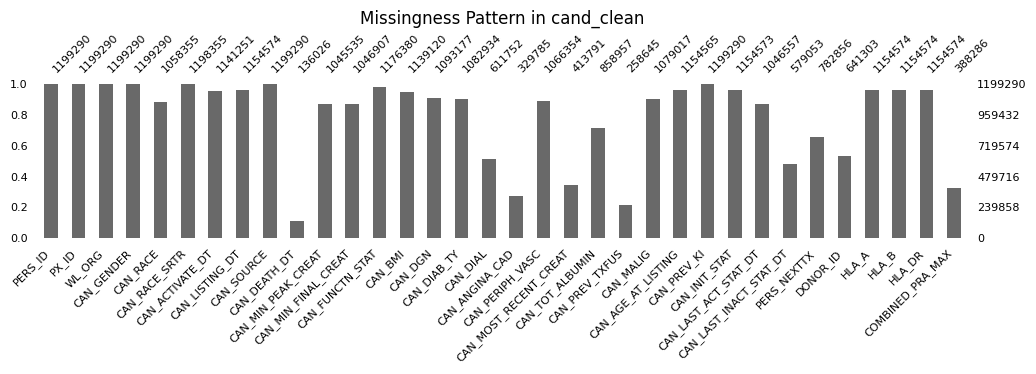

In [50]:
miss_pct = cand_clean.isna().mean().mul(100).sort_values(ascending=False)
missingness_df = miss_pct.to_frame(name="missing_pct")

display(missingness_df)

plt.figure(figsize=(12, 2))
msno.bar(cand_clean, fontsize=8, figsize=(12, 2))
plt.title("Missingness Pattern in cand_clean")
plt.show()

In [52]:
OUT_DIR = "/Users/chanyoungwoo/Thesis/Data_Extraction/clean_subsets_ver1"
os.makedirs(OUT_DIR, exist_ok=True)

# write cand_clean to CSV
out_path = os.path.join(OUT_DIR, "cand_kipa_clean.csv")
cand_clean.to_csv(out_path, index=False)
print(f"Saved cleaned CAND_KIPA subset to {out_path}")

Saved cleaned CAND_KIPA subset to /Users/chanyoungwoo/Thesis/Data_Extraction/clean_subsets_ver1/cand_kipa_clean.csv
